## Morphological stellar mass of a galaxy
# <hr></hr>
## <u> Problem statement :</u>
### Galaxies are gravitationally bound systems of stars, gas, and dust. They come in a large variety of sizes and shapes, but most of them can be roughly classified in two groups: spiral galaxies and elliptical galaxies. Ellipticals are featureless blobs, whereas spirals are disk galaxies with spiral arms and a central bulge.

### To learn about galaxy formation, we must able to estimate its properties. One of the interesting property is stellar mass. stellar mass of galaxy is total mass of all stars. Number of stars in galaxy, stellar mass and total light are directly proportional. so mass-to-light <i>(M/L)</i> is an interesting property. This property is estimated through different observations with different wavelengths. if the value is lower,the galaxy has young stars and blue in color.

### The question we are interested in here is:<i>can we estimate the <i>M/L</i> using a single observation, at one wavelength?</i> Our dataset has images of the g-band (around 475 nm: blue). It is a supervised regression problem. Supervised, since the dataset actually has more observations and thus an accurate ground truth <i>M/L</i>. Regression, since the <i>M/L</i> is a continuous variable.

### This notebook helps to get  started with data, transformations, model and evaluation.

## <u> Data :
### Galaxy metadata can be found in <i>metadata.csv</i>. This contains the target <i>M/L</i>, as well as some other galaxy properties: the distance to the galaxy, the total g-band luminosity, and the size of the galaxy.
### The images have been preprocessed. Some foreground contamination has been removed. The images have been log-scaled (this results in a more clear view of the fainter features). They are all cropped around the center of the galaxy, and then resized (one dataset uses 69x69 pixels, the other 128x128).
    
## <u> Getting started:</u>
### This notebook is should work with latest Pytorch 1.0,pandas,numpy. To run the notebooks, either jupyter notebook or jupyter lab is required. Care has to be taken to have the right CUDA toolkit version for Pytorch 1.0.

## Load (import) python and python based machine learning libraries

In [4]:
import numpy as np
import pandas as pd
import os
import math

import PIL
from PIL import Image

import torch
from torch import *
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

import pycuda.driver as cuda
cuda.init()
torch.cuda.current_device()
cuda.Device(0).name()
torch.cuda.set_device(0) 

import matplotlib.pyplot as plt

##  Loading and normalizing

### <p>Galaxies train and test  g-band images folder 's abosulute paths are assignied to path variable and plotted before applying transformation and also plotted after applying transformation.</p>
### <p> Dataset and dataLoader for train and test set is created.</p>

In [18]:
"""
Test_dir : An absolute path for test images.
Train_dir : An absolute path for train images.

"""
# Test_dir =  "./128_test5K/"
Test_dir = "C:/FILES/Astrohack/128_test5K/"
# Train_dir ="./128pix_10K/"
Train_dir = "C:/FILES/Astrohack/128pix_Train30K/"

(<matplotlib.axes._subplots.AxesSubplot at 0x25c3c7d5448>,
 <matplotlib.image.AxesImage at 0x25c3c9a2f88>)

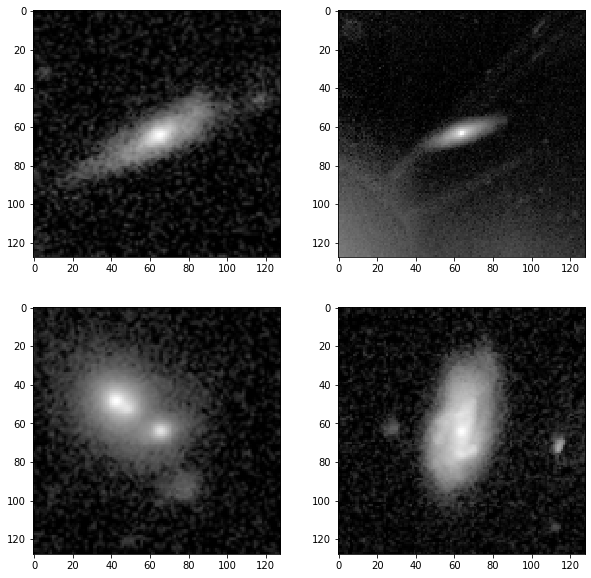

In [19]:
"""Plot galaxy images before applying transformation.
"""

plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(Image.open(os.path.join(Train_dir,os.listdir(Train_dir)[0])), cmap='gray')
plt.subplot(222), plt.imshow(Image.open(os.path.join(Train_dir,os.listdir(Train_dir)[1])), cmap='gray')
plt.subplot(223), plt.imshow(Image.open(os.path.join(Train_dir,os.listdir(Train_dir)[2])), cmap='gray')
plt.subplot(224), plt.imshow(Image.open(os.path.join(Train_dir,os.listdir(Train_dir)[3])), cmap='gray')

In [20]:
""" Transform object is list of transformation that every images should get through it.
    - Image get flipped horizontally.
    - RGB image get converted to greyscale.
    - Weights in image get normalised.
"""
transform = transforms.Compose([transforms.RandomHorizontalFlip(), \
                                transforms.Grayscale(),\
                                transforms.ToTensor() ,\
                                transforms.Normalize((0.5,), (0.5,)) \
                               ])

(<matplotlib.axes._subplots.AxesSubplot at 0x25c3cad41c8>,
 <matplotlib.image.AxesImage at 0x25c3cad4048>)

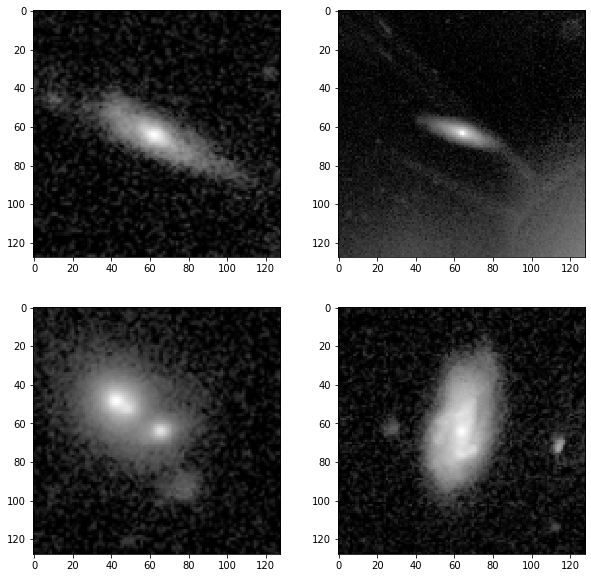

In [21]:
""" Plot images of galaxies after get transformed 
"""
plt.figure(figsize=(10,10))

plt.subplot(221), plt.imshow(transform(Image.open(os.path.join(Train_dir,os.listdir(Train_dir)[0]))).numpy()[0], cmap='gray')
plt.subplot(222), plt.imshow(transform(Image.open(os.path.join(Train_dir,os.listdir(Train_dir)[1]))).numpy()[0], cmap='gray')
plt.subplot(223), plt.imshow(transform(Image.open(os.path.join(Train_dir,os.listdir(Train_dir)[2]))).numpy()[0], cmap='gray')
plt.subplot(224),plt.imshow(transform(Image.open(os.path.join(Train_dir,os.listdir(Train_dir)[3]))).numpy()[0], cmap='gray')

In [22]:
""" A class to load images of galaxies,its corresponding metadata and apply transformation to preprocess the images.
    GimageLoad : A dataset class, which is defined to load images and its corresponding mass-to-light value as label.
    
    Parameters : 
        dataFile : A metadata file, which consists of image name to load,corresponding M/L value and it should present in rootdir.
        rootdir  : A path variable, path should have of images to load and metadata file.
        transform : List of transformation to apply on image.
        
    Return : Returns image and it corresponding mass-to-light value.
"""
class GimageLoad(torch.utils.data.Dataset):
    def __init__(self,dataFile,rootdir,transform=None):
        self.imageName = pd.read_csv(os.path.join(rootdir,dataFile),usecols=['FileNames'])
        self.label =  pd.read_csv(os.path.join(rootdir,dataFile),usecols=['M/L'])
        self.root_dir = rootdir
        self.transform = transform
    def __len__(self):
        return len(self.imageName)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.imageName.iloc[idx, 0])
        image = Image.open(img_name)
        
        image = self.transform(image)
        labels = self.label.iloc[idx, 0]

        return image,labels
    


In [26]:
Test_dir

'C:/FILES/Astrohack/128_test5K/'

In [ ]:
pd.read_csv("C:/FILES/Astrohack/128_test5K/128_test5k.csv")

In [29]:
"""
A dataset and dataloader object is created for train,test images.

    smimage_load_train : A dataset object for train set.
    simageTrainLoader  : A dataloader object for train set.
    
    smimage_load_test  : A dataset object for test set.
    simageTestLoader   : A dataloader object for test set.
    
"""
smimage_load_train = GimageLoad("128px_Train30k.csv", Train_dir,transform)

simageTrainLoader = torch.utils.data.DataLoader(smimage_load_train,batch_size=16,shuffle=True,num_workers=10)

smimage_load_test = GimageLoad("128_test5k.csv", Test_dir,transform)

simageTestLoader = torch.utils.data.DataLoader(smimage_load_test,batch_size=16,shuffle=True,num_workers=10)

(<matplotlib.axes._subplots.AxesSubplot at 0x25c4334d688>,
 <matplotlib.image.AxesImage at 0x25c4334dc08>)

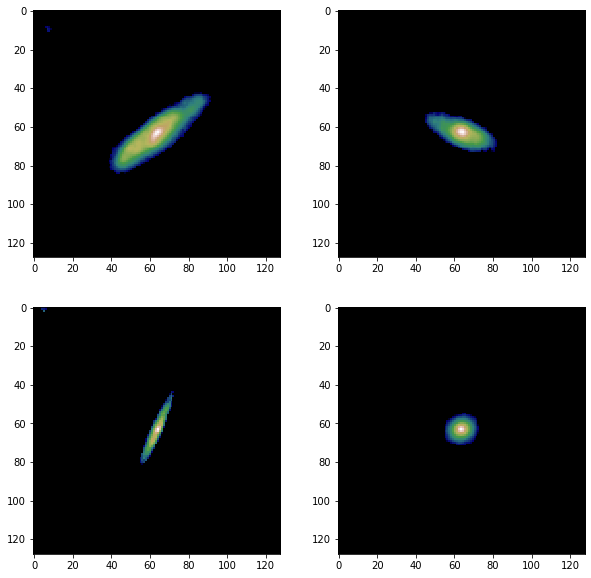

In [80]:
""" 
Plot images of galaxies transformed,scaled and processed through GimageLoad dataset and torch.utils dataloader.
"""
images = []
for i,data in enumerate(torch.utils.data.DataLoader(smimage_load_test,batch_size=1,shuffle=True)):
    
    for img  in data[0].numpy():
        images.append(img[0])
    if i == 5:
        break

plt.figure(figsize=(10,10))

plt.subplot(221), plt.imshow(Image.fromarray(np.uint8(plt.cm.gist_earth(images[0])*255)), cmap='gray')
plt.subplot(222), plt.imshow(Image.fromarray(np.uint8(plt.cm.gist_earth(images[1])*255)), cmap='gray')
plt.subplot(223), plt.imshow(Image.fromarray(np.uint8(plt.cm.gist_earth(images[2])*255)), cmap='gray')
plt.subplot(224),plt.imshow(Image.fromarray(np.uint8(plt.cm.gist_earth(images[3])*255)), cmap='gray')

# Define a Convolutional Neural Network

#### As input, a CNN takes tensors of shape (image_height, image_width, color_channels). since here images are greyscale, number of channel is 1. Instantiated model is moved to GPU.

In [81]:
""" CNN , A class to define convolution neural network model.

    Parameter : CNN class is inherits all properties from nn.Module in pytorch library.
    
    Return    : A CNN instatiated model.
"""


class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.5))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.5))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(0.5))

        self.fc1 = torch.nn.Linear(36992, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5))
        self.fc2 = torch.nn.Linear(625, 1, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# instantiate CNN model
simage_cnn = CNN()
simage_cnn.to(torch.device("cuda:0"))

C:\Users\haek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


### Define a Loss function and optimizer
<hr></hr>

#### Loss function : SmoothL1Loss.
#### <b> It uses a squared term if the absolute error falls below 1 and an absolute term otherwise. It is less sensitive to outliers than the mean square error loss and in some cases prevents exploding gradients. In mean square error loss, we square the difference which results in a number which is much larger than the original number. These high values result in exploding gradients. This is avoided here as for numbers greater than 1, the numbers are not squared.

In [20]:
""" L1LossFlat ,a class to define loss, 
    Paramater : inherits all properties and function of smoothl1loss.
    
    Return :  A loss value.

"""
class L1LossFlat(nn.SmoothL1Loss):
    def forward(self, in1:torch.Tensor, target:torch.Tensor):
        return super().forward(in1.view(-1), target.view(-1))

In [ ]:
""" Cyclic learning rate.
cyclical learning rates, which practically eliminates the need to experimentally find the best values and 
schedule for the global learning rates. Instead of monotonically decreasing the learning rate, 
this method lets the learning rate cyclically vary between reasonable boundary values.
Training with cyclical learning rates instead of fixed values achieves improved
classification accuracy without a need to tune and often in fewer iterations

"""
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

## Train the network

#### We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [34]:
import time

def trainNet(model, batch_size, n_epochs, learning_rate,checkpoint_path=os.getcwd()):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    min_val_loss = np.Inf
    epochs_no_improve = 0
    factor = 3 
    end_lr=1e-3
    
    model.train()
    #Get training data
    train_loader = simageTrainLoader
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
#     loss = L1LossFlat()
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    loss = L1LossFlat()
    
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=1.)
#     step_size = 4*len(train_loader)
#     clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
#     scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = model(inputs)
#             print(len(outputs))
            loss_size = loss(outputs, labels.float())
            loss_size.backward()
        
#             scheduler.step()
            
            optimizer.step()
#             print(loss_size.data)
            #Print statistics
            running_loss += loss_size.data
            total_train_loss += loss_size.data
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in simageTestLoader:
            
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = model(inputs)
            val_loss_size = loss(val_outputs, labels.float())
#             print(val_loss_size.data)
            total_val_loss += val_loss_size.data
    
        val_loss = total_val_loss / len(simageTestLoader)
        print(val_loss)
        if val_loss < min_val_loss:
              # Save the model
                torch.save(model, "checkpoint_path")
                epochs_no_improve = 0
                min_val_loss = val_loss
  
        else:
          epochs_no_improve += 1
          # Check early stopping condition
          if epochs_no_improve == n_epochs:
            print('Early stopping!')

            # Load in the best model
            model = torch.load(checkpoint_path)


        print("Validation loss = {:.2f}".format(total_val_loss / len(simageTestLoader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    
    return model

In [36]:
simage_cnn = CNN()
simage_cnn.to(torch.device("cuda:0"))

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=36992, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=36992, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=1, bias=True

In [37]:
simage_cnn1 = trainNet(simage_cnn, batch_size=128, n_epochs=20, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 128
epochs= 20
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 0.67 took: 4.03s
Epoch 1, 20% 	 train_loss: 0.64 took: 3.38s
Epoch 1, 30% 	 train_loss: 0.64 took: 3.38s
Epoch 1, 40% 	 train_loss: 0.65 took: 3.38s
Epoch 1, 50% 	 train_loss: 0.61 took: 3.37s
Epoch 1, 60% 	 train_loss: 0.60 took: 3.38s
Epoch 1, 70% 	 train_loss: 0.60 took: 3.38s
Epoch 1, 80% 	 train_loss: 0.62 took: 3.38s
Epoch 1, 90% 	 train_loss: 0.59 took: 3.38s
tensor(0.5620, device='cuda:0')


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Validation loss = 0.56
Epoch 2, 10% 	 train_loss: 0.59 took: 3.80s
Epoch 2, 20% 	 train_loss: 0.58 took: 3.38s
Epoch 2, 30% 	 train_loss: 0.58 took: 3.39s
Epoch 2, 40% 	 train_loss: 0.58 took: 3.38s
Epoch 2, 50% 	 train_loss: 0.54 took: 3.39s
Epoch 2, 60% 	 train_loss: 0.58 took: 3.38s
Epoch 2, 70% 	 train_loss: 0.57 took: 3.39s
Epoch 2, 80% 	 train_loss: 0.55 took: 3.38s
Epoch 2, 90% 	 train_loss: 0.54 took: 3.39s
tensor(0.5334, device='cuda:0')
Validation loss = 0.53
Epoch 3, 10% 	 train_loss: 0.55 took: 3.82s
Epoch 3, 20% 	 train_loss: 0.54 took: 3.39s
Epoch 3, 30% 	 train_loss: 0.56 took: 3.38s
Epoch 3, 40% 	 train_loss: 0.55 took: 3.39s
Epoch 3, 50% 	 train_loss: 0.54 took: 3.38s
Epoch 3, 60% 	 train_loss: 0.50 took: 3.39s
Epoch 3, 70% 	 train_loss: 0.53 took: 3.38s
Epoch 3, 80% 	 train_loss: 0.55 took: 3.39s
Epoch 3, 90% 	 train_loss: 0.52 took: 3.38s
tensor(0.5074, device='cuda:0')
Validation loss = 0.51
Epoch 4, 10% 	 train_loss: 0.50 took: 3.83s
Epoch 4, 20% 	 train_loss: 0.52

Validation loss = 0.44
Epoch 20, 10% 	 train_loss: 0.45 took: 3.82s
Epoch 20, 20% 	 train_loss: 0.46 took: 3.38s
Epoch 20, 30% 	 train_loss: 0.45 took: 3.38s
Epoch 20, 40% 	 train_loss: 0.46 took: 3.37s
Epoch 20, 50% 	 train_loss: 0.47 took: 3.37s
Epoch 20, 60% 	 train_loss: 0.46 took: 3.37s
Epoch 20, 70% 	 train_loss: 0.48 took: 3.37s
Epoch 20, 80% 	 train_loss: 0.46 took: 3.38s
Epoch 20, 90% 	 train_loss: 0.47 took: 3.37s
tensor(0.4361, device='cuda:0')
Validation loss = 0.44
Training finished, took 761.77s


### Test/Evaluate the network on the test data

In [25]:
smimage_load_test_pred = GimageLoad("128_test5k.csv", dest_dir,transform)

simageTestLoader_test = torch.utils.data.DataLoader(smimage_load_test_pred,batch_size=1,shuffle=True)

torch.cuda.empty_cache()

val_pred_y = []
val_true_y = []
simage_cnn1.eval()
for inputs, labels in simageTestLoader_test:
            inputs = inputs.cuda()

            inputs = Variable(inputs.float())

            j = simage_cnn1(inputs)
            i_pred = float(j[0][0].cpu().detach().numpy())
            val_pred_y.append(i_pred)
            val_true_y.append(float(labels[0].numpy()))

In [40]:
torch.save(simage_cnn1,"smass_torch.pth")

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


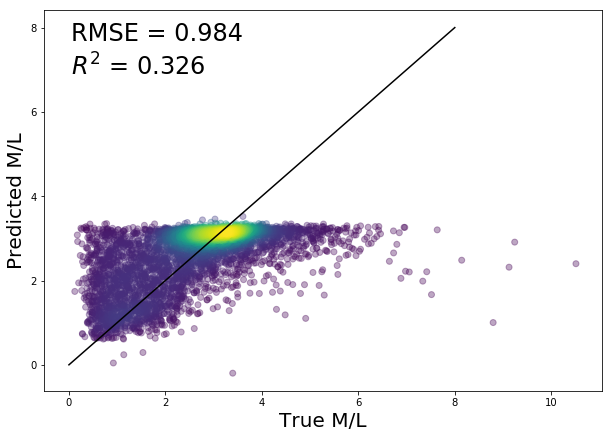

In [32]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def estimate_density(x, y, **kwargs):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, **kwargs)
    z = kde(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

def r2(yt, yp):
    ybar = np.mean(yt)
    return 1 - (np.sum(np.square(yt - yp)) / np.sum(np.square(yt - ybar)))

def plot_truevspred():
    y = np.array(val_true_i)
    y_pred = np.array(val_pred_i)
    rmse_val = rmse(y, y_pred)
    r2_val = r2(y, y_pred)
    
    xc, yc, c = estimate_density(y, y_pred)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 7))
    plt.scatter(xc, yc, c=c, alpha=0.35)
    plt.xlabel('True M/L')
    plt.ylabel('Predicted M/L')
    plt.plot([0, 8], [0, 8], 'k-')
    ax = plt.gca()
    fontsize = 24
    plt.text(0.05, 0.92, f'RMSE = {rmse_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    plt.text(0.05, 0.83, f'$R^2$ = {r2_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    
plot_truevspred()